In [1]:
import dolfin as dl
import matplotlib.pyplot as plt
import mshr
import numpy as np
from scipy.optimize import fsolve
%matplotlib inline

In [2]:
# Read a Unit Square Mesh
def square_mesh(MeshDensity, Length):
    domain = mshr.Rectangle(dl.Point(-Length/2, -Length/2), dl.Point(Length/2, Length/2))
    mesh = mshr.generate_mesh(domain, MeshDensity); geoDimension = mesh.topology().dim()
    geoDimension = mesh.topology().dim()
    return mesh, geoDimension

def function_space(mesh, elementDegree):
    displacement = dl.VectorElement('CG', dl.triangle, elementDegree)
    lagrange_coefficient = dl.FiniteElement('CG', dl.triangle, 1)
    e_33 = dl.FiniteElement('CG', dl.triangle, 1)
    element = dl.MixedElement([displacement, lagrange_coefficient, e_33])
    
    V  = dl.FunctionSpace(mesh, element)
    return V

def boundary_condition(mesh, geoDimension, V):
    # define boundary subdomains
    tol = 1e-8

    class Left(dl.SubDomain):
        def inside(self, x, on_boundary):
            return dl.near(x[0], -Length/2, tol)

    class Right(dl.SubDomain):
        def inside(self, x, on_boundary):
            return dl.near(x[0], +Length/2, tol)

    class Top(dl.SubDomain):
        def inside(self, x, on_boundary):
            return dl.near(x[1], Length/2, tol)

    class Bottom(dl.SubDomain):
        def inside(self, x, on_boundary):
            return dl.near(x[1], -Length/2, tol)

    left = Left()
    right = Right()
    top = Top()
    bottom = Bottom()
    # mark boundary subdomains with markers 1, 2, 3, 4
    boundaries = dl.MeshFunction("size_t", mesh, geoDimension-1, 0)
    boundaries.set_all(0)
    left.mark(boundaries, 1)
    right.mark(boundaries, 2)
    top.mark(boundaries, 3)
    bottom.mark(boundaries, 4)

    # compile surface integration
    ds = dl.Measure('ds', domain=mesh, subdomain_data=boundaries)
    
    # fix extra point to rule out rigid body motion
    tol = 1e-6
    def fixPoint(x, on_boundary):
        return dl.near(x[0], -Length/2, tol) and dl.near(x[1], -Length/2, tol)
    bc_left_X  = dl.DirichletBC(V.sub(0), dl.Constant(0.0), left)
    bc_left_Y  = dl.DirichletBC(V.sub(1), dl.Constant(0.0), fixPoint, method="pointwise")

    bcs = [bc_left_X, bc_left_Y]
    return ds, bcs

def epsilon(u):
    return dl.sym(dl.grad(u))

# elastic constants
E = 200; nu = 0.3
# convert to Lame constants
mu = E/2/(1+nu); lmbda = E*nu/(1+nu)/(1-2*nu)
# convert to bulk and shear modulus
mu = E/2/(1+nu); kappa = E/(1-2*nu)/3 #E/(1-2*nu)
# nonlinear parameters:
n = 1.5; s0 = 1.0; e0 = 0.005;
    


In [3]:
def nonlinear_plain_stress(mesh, geoDimension, traction):
   
    #define vector function space, function u, and test function v
    w  = dl.Function(V)
    w_  = dl.TestFunction(V)
    dw = dl.TrialFunction(V)
    
    u, lbd, e_33= dl.split(w)
    #print(u)
    #print(w)
    ds, bcs = boundary_condition(mesh, geoDimension, V.sub(0))
    # define strain

    
    # LINEAR STRAIN ENERGY DENSITY, rule sigularity
    def Psi_linear(u, e_33):
        eps = epsilon(u)
        sigma = 2*mu*eps + lmbda*dl.tr(eps)*dl.Identity(geoDimension)
        ev = dl.tr(eps) + e_33
        return 1/2 * ( dl.inner(sigma, eps) + (2*mu*e_33 + lmbda*ev)*e_33 ) 
    def constrain_linear(u, e_33):
        eps = epsilon(u)
        ev = dl.tr(eps) + e_33
        return 2*mu*e_33 + lmbda*ev
    
    #u  = dl.Function(V.sub(0))
    v  = dl.TestFunction(V.sub(0))
    du = dl.TrialFunction(V.sub(0))
    # define traction 
    T = dl.Constant(0.1)
    # initialize vector to be 0
    w.vector()[:] = 0
    # minimize potential energy
    Pi = (Psi_linear(u, e_33) + lbd * constrain_linear(u, e_33)) * dl.dx - T*u[0]*ds(2) 
    Res = dl.derivative(Pi, w, w_)
    dl.solve(Res == 0, w, bcs)
    # calculate potential energy
    #print("Linear Elasticity, Potential Energy = ", dl.assemble(Pi))
    
    # POWER LAW NONLINEAR ELASTIC MATERIAL
    def Psi_nonlinear(u, e_33):
        eps = epsilon(u)
        ev = dl.tr(eps) + e_33
        e = eps - ev * dl.Identity(geoDimension)/3
        e_e2 =  (dl.inner(e, e) + (e_33-1/3.0*ev)**2 ) * 2/3
        m = (n+1)/n/2;
        return kappa/2.*ev**2 + 1/(2 * m) * s0*e0*(e_e2/e0**2)**m 
    
    def constrain(u, e_33):
        eps = epsilon(u)
        ev = dl.tr(eps) + e_33
        e = eps - ev * dl.Identity(geoDimension)/3
        e_e2 =  (dl.inner(e, e) + (e_33-1/3.0*ev)**2 ) * 2/3
        return kappa * ev + 2.0/3.0*s0/e0*(e_e2/e0**2)**(-(n-1)/2/n)*(e_33 - ev/3.0)
    
    # larger traction
    T.assign(traction)

    # minimize potential energy
    Pi = (Psi_nonlinear(u, e_33) + lbd * constrain(u, e_33)) * dl.dx - T*u[0]*ds(2)
    Res = dl.derivative(Pi, w, w_)
    dl.solve(Res == 0, w, bcs)

    # calculate potential energy
    #print("Nonlinear Elasticity, Potential Energy = ", dl.assemble(Pi))
    return u, e_33


In [4]:
MeshDensity = 10; Length = 1;
mesh, geoDimension = square_mesh(MeshDensity, Length)
#dl.plot(mesh)
#u = nonlinear_plain_strain(mesh, geoDimension, 1)
#dl.plot(u, mode="displacement")

elementDegree = 1
V  = function_space(mesh, elementDegree)

ds, bcs = boundary_condition(mesh, geoDimension, V.sub(0))

In [5]:
traction = 1;
u, e_33 = nonlinear_plain_stress(mesh, geoDimension, traction)

Calling FFC just-in-time (JIT) compiler, this may take some time.
[8.24780528e-07 1.17048731e-06 1.66824163e-06 2.38880505e-06
 3.43788809e-06 4.97439959e-06 7.23868321e-06 1.05964043e-05
 1.56070467e-05 2.31312287e-05 3.44994087e-05 5.17779154e-05
 7.81895894e-05 1.18780497e-04 1.81478914e-04 2.78780505e-04
 4.30434341e-04 6.67730241e-04 1.04035048e-03 1.62733142e-03
 2.55461632e-03 4.02318527e-03 6.35416628e-03 1.00612215e-02
 1.59667584e-02 2.53885792e-02 4.04397762e-02 6.45107343e-02
 1.03044036e-01 1.64780550e-01] [1.00000000e-03 1.37382380e-03 1.88739182e-03 2.59294380e-03
 3.56224789e-03 4.89390092e-03 6.72335754e-03 9.23670857e-03
 1.26896100e-02 1.74332882e-02 2.39502662e-02 3.29034456e-02
 4.52035366e-02 6.21016942e-02 8.53167852e-02 1.17210230e-01
 1.61026203e-01 2.21221629e-01 3.03919538e-01 4.17531894e-01
 5.73615251e-01 7.88046282e-01 1.08263673e+00 1.48735211e+00
 2.04335972e+00 2.80721620e+00 3.85662042e+00 5.29831691e+00
 7.27895384e+00 1.00000000e+01]


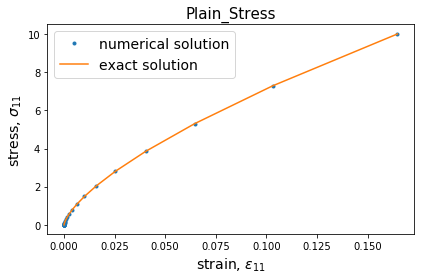

In [6]:
ts = np.logspace(-3, np.log10(10), 30)

us = []
for t in ts:
    u, e_33 = nonlinear_plain_stress(mesh, geoDimension, t)
    us.append(dl.assemble(u[0]*ds(2)))

us = np.array(us)
#print(us, ts)
plt.plot(us, ts, '.', label="numerical solution")

# 请给 e_analytical 一个正确的表达式
e_analytical = ts/9/kappa + e0*(ts/s0)**(n)
plt.plot(e_analytical * Length, ts, label="exact solution")
plt.legend(fontsize=14)
plt.xlabel("strain, $\\epsilon_{11}$", fontsize=14);
plt.ylabel("stress, $\\sigma_{11}$", fontsize=14);
plt.title("Plain_Stress", fontsize=15)
plt.tight_layout()
plt.savefig("stress-strain-curve.png")